In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
class RegressionAnalyser:
    def __init__(self, path, missing_data=None, categorical_data=None, label_encoding=False):
        self.dataset = pd.read_csv(path)
        self.result = dict()
        self.X = self.dataset.iloc[:, :-1].values
        self.y = self.dataset.iloc[:, -1].values

        # Handling Missing Data
        if missing_data is not None:
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputer.fit(self.X[:, missing_data])
            self.X[:, missing_data] = imputer.transform(self.X[:, missing_data])

        # Category Data Encoding
        if categorical_data is not None:
            from sklearn.compose import ColumnTransformer
            from sklearn.preprocessing import OneHotEncoder
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_data)], remainder='passthrough')
            self.X = np.array(ct.fit_transform(self.X))

        # Label Encoding
        if label_encoding:
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            self.y = le.fit_transform(self.y)

        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        self.sc_x = StandardScaler()
        self.sc_y = StandardScaler()
        self.X_sc = self.sc_x.fit_transform(self.X)
        self.y_sc = self.sc_y.fit_transform(self.y.reshape(-1, 1)).reshape(-1)


    def k_fold_cross_validation(self, model, cv=10, xtrain=None, ytrain=None):
        if xtrain is None:
            xtrain = self.X
        if ytrain is None:
            ytrain = self.y
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(estimator=model, X=xtrain, y=ytrain, cv=cv, scoring='r2')
        return scores.mean(), scores.std()


    def grid_search(self, model, param_grid, scoring='r2', cv=10, xtrain=None, ytrain=None):
        if xtrain is None:
            xtrain = self.X
        if ytrain is None:
            ytrain = self.y
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1)
        grid_search.fit(xtrain, ytrain)
        return grid_search.best_params_, grid_search.best_score_


    def linear_regression(self):
        from sklearn.linear_model import LinearRegression

        # Create a Linear Regression model instance
        model = LinearRegression()

        # Define parameters for grid search
        linear_regression_parameters = {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'positive': [True, False]
        }

        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, linear_regression_parameters)

        # Reassign the model instance with the best parameters found
        model = LinearRegression(**best_params)

        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model)

        # Store the result
        self.result['linear_regression'] = (mean_score, std_score, best_params)

        # Print the results
        print('Linear Regression:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)

        # Return the best parameters for further analysis if needed
        return best_params


    def polynomial_regression(self):
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression

        best_degree = 0
        best_score = float('-inf')  # Initialize with negative infinity
        best_std_score = 0  # Initialize with 0

        for degree in range(2, 10):
            poly_reg = PolynomialFeatures(degree=degree)
            X_poly_train = poly_reg.fit_transform(self.X)

            model = LinearRegression()
            mean_score, std_score = self.k_fold_cross_validation(model, xtrain=X_poly_train)

            if mean_score > best_score:
                best_score = mean_score
                best_std_score = std_score  # Update the best standard deviation
                best_degree = degree

        # Store the result for the best polynomial degree
        self.result['polynomial_regression'] = (best_score, best_std_score, best_degree)

        # Print the results
        print('Polynomial Regression:')
        print('Mean R-squared Score:', best_score)
        print('Standard Deviation of R-squared Score:', best_std_score)
        print('Best Polynomial Degree:', best_degree)

        # Return the best degree for further analysis if needed
        return best_degree


    def support_vector_regression(self):
        from sklearn.svm import SVR

        # Initialize SVR model
        model = SVR()

        # Define parameter grid for grid search
        support_vector_regression_parameters = {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5],
            'gamma': ['scale', 'auto']
        }

        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, support_vector_regression_parameters, scoring='r2', xtrain=self.X_sc, ytrain=self.y_sc)

        # Reassign the model instance with the best parameters found
        model = SVR(**best_params)

        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model, xtrain=self.X_sc, ytrain=self.y_sc)

        # Store the result
        self.result['support_vector_regression'] = (mean_score, std_score, best_params)

        # Print the results
        print('Support Vector Regression:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)

        # Return the best parameters for further analysis if needed
        return best_params


    def decision_tree_regression(self):
        from sklearn.tree import DecisionTreeRegressor

        # Initialize Decision Tree Regressor
        model = DecisionTreeRegressor()

        # Define parameter grid for grid search
        decision_tree_regression_parameters = {
            'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error'],
            'splitter': ['best', 'random']
        }

        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, decision_tree_regression_parameters, scoring='r2')

        # Reassign the model instance with the best parameters found
        model = DecisionTreeRegressor(**best_params)

        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model)

        # Store the result
        self.result['decision_tree_regression'] = (mean_score, std_score, best_params)

        # Print the results
        print('Decision Tree Regression:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)

        # Return the best parameters for further analysis if needed
        return best_params


    def random_forest_regression(self):
        from sklearn.ensemble import RandomForestRegressor

        # Initialize Random Forest Regressor
        model = RandomForestRegressor()

        # Define parameter grid for grid search
        random_forest_regression_parameters = {
            'n_estimators': [10, 100, 1000],
            'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']  # Update the criterion parameter
        }


        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, random_forest_regression_parameters, scoring='r2')

        # Reassign the model instance with the best parameters found
        model = RandomForestRegressor(**best_params)

        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model)

        # Store the result
        self.result['random_forest_regression'] = (mean_score, std_score, best_params)

        # Print the results
        print('Random Forest Regression:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)

        # Return the best parameters for further analysis if needed
        return best_params


    def XGBoost(self):
        from xgboost import XGBRegressor

        # Initialize XGBoost Regressor
        model = XGBRegressor()

        # Define parameter grid for grid search
        xgboost_parameters = {
            'n_estimators': [100, 500, 1000],
            'booster': ['gbtree', 'gblinear', 'dart'],
            'learning_rate': [0.01, 0.1, 0.3]
        }

        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, xgboost_parameters, scoring='r2')

        # Reassign the model instance with the best parameters found
        model = XGBRegressor(**best_params)
        
        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model)
        
        # Store the result
        self.result['XGBoost'] = (mean_score, std_score, best_params)
        
        # Print the results
        print('XGBoost:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)
        
        # Return the best parameters for further analysis if needed
        return best_params

    
    def CatBoost(self):
        from catboost import CatBoostRegressor

        # Initialize CatBoost Regressor
        model = CatBoostRegressor()

        # Define parameter grid for grid search
        catboost_parameters = {
            'iterations': [100, 500, 1000],
            'learning_rate': [0.01, 0.1, 0.3]
        }

        # Perform grid search to find the best parameters
        best_params, best_score = self.grid_search(model, catboost_parameters, scoring='r2')

        # Reassign the model instance with the best parameters found
        model = CatBoostRegressor(**best_params)
        
        # Perform k-fold cross-validation with the tuned model
        mean_score, std_score = self.k_fold_cross_validation(model)
        
        # Store the result
        self.result['CatBoost'] = (mean_score, std_score , best_params)
        
        # Print the results
        print('CatBoost:')
        print('Mean R-squared Score:', mean_score)
        print('Standard Deviation of R-squared Score:', std_score)
        print('Best Parameters:', best_params)
        
        # Return the best parameters for further analysis if needed
        return best_params
  
    
    def analyse(self):
        self.linear_regression()
        self.polynomial_regression()
        self.support_vector_regression()
        self.decision_tree_regression()
        self.random_forest_regression()
        self.XGBoost()
        self.CatBoost()
        from pprint import pprint
        pprint(self.result)
        
    
    def plot(self):
        for key,value in self.result.items():
            plt.scatter(value[0], value[1], label=key)
        plt.title('R-squared Score vs Standard Deviation')
        plt.xlabel('Mean R-squared Score')
        plt.ylabel('Standard Deviation of R-squared Score') 
        plt.legend()
        plt.show()
        

In [54]:
analyser = RegressionAnalyser('datasets/Data.csv')

In [ ]:
analyser.analyse()

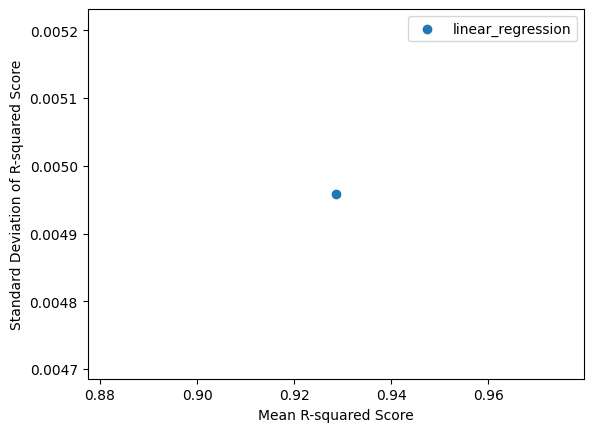

In [56]:
analyser.plot()